In [1]:
%matplotlib inline
# plot the molecule in 3D in an interactive window
# %matplotlib widget
%config InlineBackend.figure_format = 'retina'

In [2]:
# get current working directory
import os, sys
pwd = os.getcwd()
# append ../src/ to the sys path to access the coarsegrainer package
sys.path.append(pwd + '/../src/')

In [3]:
pwd

'/home/nima/__work/Coarse_graining/coarse_graining_code_2024_02/experiments'

In [4]:
import time
# import collections

import numpy as np
import pandas as pd

import torch
# import torch.nn.functional as F

import matplotlib.pyplot as plt

### import the coarse-graining module
import coarsegrainer as cg
# from coarsegrainer.minimizer import EnergyMinimizerPytorch, CGMinimizerPytorch, GNNMinimizerPytorch
# from coarsegrainer.experimental.minimizer import EnergyMinimizerPytorch, CGMinimizerPytorch, GNNMinimizerPytorch
# from coarsegrainer.experimental.minimizer import EnergyMinimizer, CGMinimizer, GNNMinimizer
from coarsegrainer.minimizer import EnergyMinimizer, CGMinimizer, GNNMinimizer
from coarsegrainer.energy import Energy, LJ_potential, quadratic_potential 
from coarsegrainer.plotting import plot_line_3D, plot_graph

from experimentlogger import ExperimentLogger

V = lambda x: x.detach().cpu().numpy()

## Quadratic Bonds + LJ loop
Define an energy function which uses a quadratic potential for bonds and LJ for forming a loop. 
It consists of:
1. a strong backbone line graph LJ, where every node is attracted to the next
2. a weaker loop LJ, where every l-th pair of nodes are attracted 

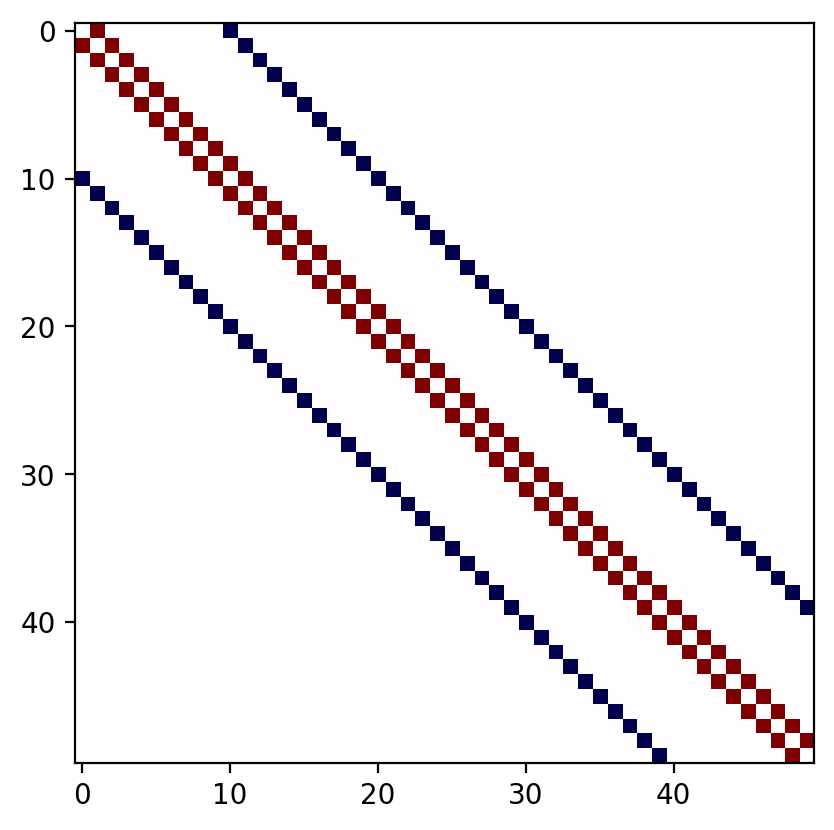

In [5]:
num_nodes, dims = 400, 3

n,d = num_nodes, dims
loop = 10
a = 1e-1

# init_sigma = 3.0 # initial standard deviation of the coordinates
# an initial std of 
init_sigma = n**(1/3)/2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

A = cg.utils.line_graph_A(n, k=1).to(device)
vdw = cg.utils.line_graph_A(n, k=loop).to(device)

A_loop = A+a*vdw

x = init_sigma*torch.randn(n, d).to(device) 

plt.imshow(V(A-vdw)[:50,:50], cmap='seismic', vmin=-1, vmax=1)

In [6]:
energy_params = dict(radius = 1, thres_A = 1e-4, lj_pow = 6, repel_pow = 1, repel_mag = 2.5e-3, 
                device = 'cuda')

energy_lj = Energy([A_loop], [LJ_potential],log_name='Energy_LJ_2scale', **energy_params)
energy_bond_lj = Energy([A, .1*vdw], [quadratic_potential, LJ_potential],log_name='Energy_Bond_LJ', **energy_params)

In [7]:
energy_bond_lj(x).item(), 
energy_lj(x).item()

0.003061961382627487

## Training

In [8]:
# early stopping criteria
PATIENCE = 20
MIN_DELTA = 1e-6

# learning rate
LR = 2e-2

In [9]:
# exp_logger = ExperimentLogger(previous_results_csv='../results/CG_experiment_2024-02-09-01.csv')
exp_logger = ExperimentLogger(save_prefix='../results/CG_Bond_LJ_experiment') 
test_logger = ExperimentLogger(save_prefix='../results/test')

In [10]:
# df = exp_logger.df

# import seaborn as sns
# # plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='min_delta', height=6, aspect=1.7)

# # plt.ylim(-.0247, -.0238)
# # plt.xlim(7,30)
# plt.xscale('log')
# plt.grid()

## LJ only

In [12]:
# example of using the EnergyMinimizerPytorch class
# define the initial position
# initial_pos = x = init_sigma*1*torch.randn(n, d).to(device) /2

initial_pos = x = init_sigma*torch.randn(n, d).to(device) /3
# instantiate the EnergyMinimizerPytorch class
# energy_minimizer = EnergyMinimizerPytorch(energy_lj, initial_pos, optimizer_type='Adam', lr=1e-2, clamp_grads=.1, log_step=20, log_pos_step=0, 
#                             log_dir='../results/logs', log_name='LJ_loop', patience=PATIENCE*1, min_delta=MIN_DELTA*1e-0)
energy_minimizer = EnergyMinimizer(energy_bond_lj, initial_pos, optimizer_type='Adam', lr=1e-3, clamp_grads=.01, log_step=20, log_pos_step=0, 
                            log_dir='../results/logs', log_name='bond_LJ', patience=PATIENCE*1, min_delta=MIN_DELTA*1e-0)

Using Adam optimizer
Log name: bond_LJ
Logging to: ../results/logs/bond_LJ_n400_d3


In [13]:
energy_minimizer.logger

In [14]:
exp_logger.run_experiment(energy_minimizer, epochs=10, steps=5000, x0_std=initial_pos.std().item())

Running experiment bond_LJ_n400_d3
250 -0.0154, 4.75
500 -0.0206, 9.19
750 -0.0225, 13.63
1000 -0.023, 18.14
1250 -0.0232, 22.59
1500 -0.0232, 27.04
1750 -0.0233, 31.53
2000 -0.0233, 36.08
Early stopping at step 3080
2155 -0.0233, 38.84


In [105]:
for i in range(10):
    h= energy_minimizer.train(20000)

Early stopping at step 2780
Early stopping at step 1820
Early stopping at step 1700
Early stopping at step 1880
Early stopping at step 1780
Early stopping at step 2600
Early stopping at step 1960
Early stopping at step 1220
Early stopping at step 1420
Early stopping at step 1160


Text(0.5, 1.0, 'Energy vs time (min E: -0.0233, t=38.84 s)')

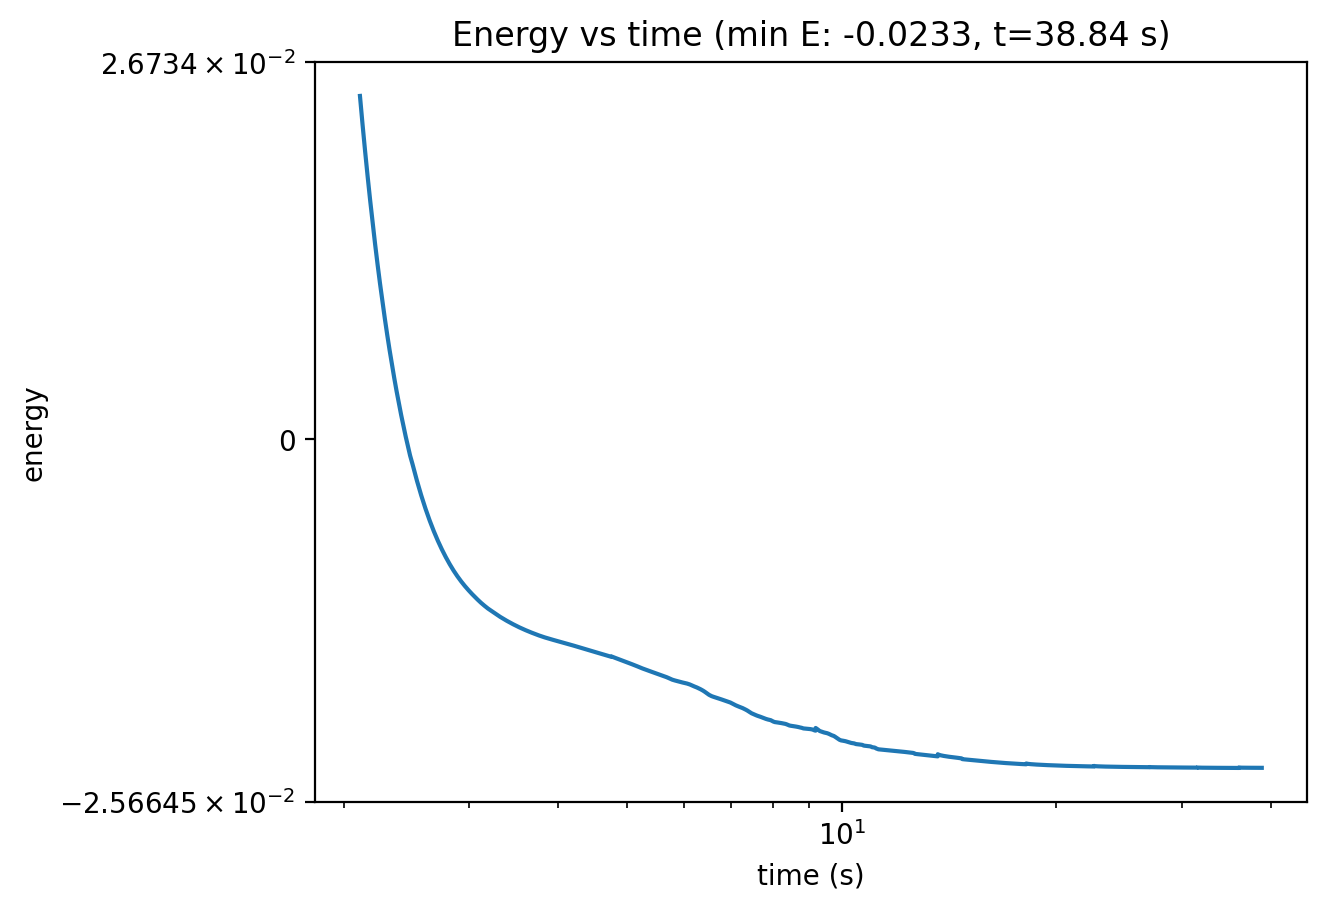

In [19]:
energy_minimizer.plot_history(start=100)
h = energy_minimizer.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g}, t={np.sum(h["time"]):.2f} s)')


In [106]:
exp_logger.df

,energy_function,model_name,energy,time,lr,clamp_grads,patience,min_delta,x0_std
0,Energy_Bond_LJ,bond_LJ_n400_d3,-0.023275,38.840646,0.001,0.01,20,1.000000e-06,1.230268
1,Energy_Bond_LJ,CG_Bond_LJ2_n400_d3,-0.023299,36.407988,0.020,0.01,20,1.000000e-08,0.927333
2,Energy_Bond_LJ,GNN_Bond_LJ2-0.33_n400_d3,0.683881,26.872083,0.020,0.01,20,1.000000e-07,0.940747
3,Energy_Bond_LJ,GNN_Bond_LJ2-0.33_n400_d3,1.133880,29.389891,0.020,0.01,20,1.000000e-07,0.916601
4,Energy_Bond_LJ,GNN_Bond_LJ2-0.25_n400_d3,0.726734,28.312771,0.020,0.01,20,1.000000e-06,0.925769
5,Energy_Bond_LJ,CG_Bond_LJ2_n400_d3,-0.023290,32.781777,0.020,0.01,20,1.000000e-08,0.911400
6,Energy_Bond_LJ,CG_Bond_LJ2_n400_d3,0.019578,29.885590,0.020,0.01,20,1.000000e-06,0.902402
7,Energy_Bond_LJ,CG_Bond_LJ2_n400_d3,-0.001856,29.030798,0.020,0.01,20,1.000000e-06,0.937966


In [107]:
energy_minimizer.get_x().std(), init_sigma

(tensor(4.5716, device='cuda:0', grad_fn=<StdBackward0>), 3.6840314986403864)

In [108]:
r = 2.5e-1
# v = plot_graph_3D(V(energy_minimizer.get_x()), A,  node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='blue', edge_color='blue')
v = plot_line_3D(V(energy_minimizer.get_x()), A, r = r, eps=1e-4, colormap='jet')
# Capture the current view as a PNG image
# v.png()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [20]:
# exp_logger = ExperimentLogger(previous_results_csv='../results/CG_experiment_2024-02-09-01.csv')
exp_logger = ExperimentLogger(save_prefix='../results/CG_Bond_LJ_experiment') 
test_logger = ExperimentLogger(save_prefix='../results/test')

In [15]:
h = energy_minimizer.train(5000)

Early stopping at step 4080


In [14]:
exp_logger.df

,energy_function,model_name,energy,time,lr,clamp_grads,patience,min_delta,x0_std
0,Energy_LJ_2scale,LJ_loop_n400_d3,-0.006895,35.318704,0.001,0.01,20,0.000001,1.292495


In [15]:
energy_minimizer.get_x().std(), init_sigma

(tensor(5.5694, device='cuda:0', grad_fn=<StdBackward0>), 3.6840314986403864)

### CG Using multiple samples

In [9]:
init_sigma

3.6840314986403864

In [77]:
t0 = time.time()
# x_samples = init_sigma/2*torch.randn(4*n, n, d, device =device)
# note: large init_sigma resulted in diverging hessian
# x_samples = init_sigma*1*torch.randn(4*n, n, d, device =device)
k = 40
# produce k samples with different std for x
# x_samples = init_sigma*torch.randn(k, n, d, device =device)*torch.linspace(1e-2, 2e-1, k)[:, None, None].to(device)
x_samples = init_sigma*torch.randn(k, n, d, device =device)*torch.linspace(1e-0, 4e-0, k)[:, None, None].to(device)
cg_bond_lj = cg.CG.CoarseGrainer(energy_bond_lj, num_cg_modes=120)
cg_bond_lj.get_cg_modes(x_samples)
cg_time = time.time() - t0
print(f'CG time {cg_time:.3g}')

force constant matrix computed in 0.34 seconds
spectrum of the Laplacian computed in 0.01 seconds
CG time 0.354


In [78]:
init_sigma/16, 1/(2*d)

(0.23025196866502415, 0.16666666666666666)

In [79]:
A.shape, x.shape

(torch.Size([400, 400]), torch.Size([400, 3]))

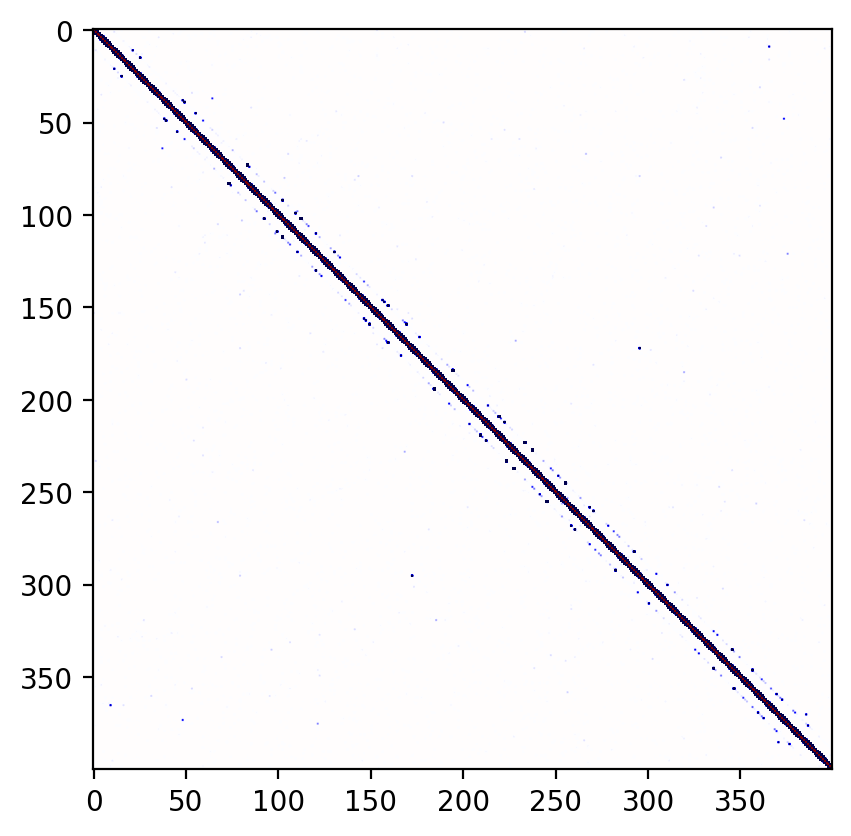

In [80]:
b = 1e-3
plt.imshow(np.arcsinh(1e3*V(cg_bond_lj.L)), cmap='seismic', vmin=-b, vmax=b)


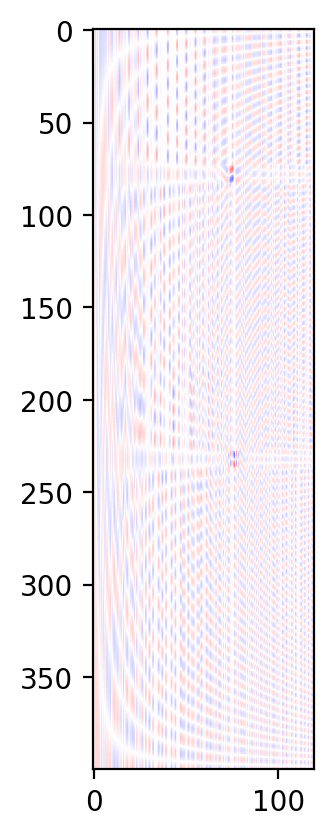

In [81]:
c = V(cg_bond_lj.cg_modes)
plt.imshow(c, cmap='seismic', vmin=-1, vmax=1) 

In [82]:
# cg_minimizer.start_fine_graining()
# cg_minimizer.early_stopping_triggered = False
# h = cg_minimizer.train(20000)

### Multi-stage CG
gradually increase the number cg modes used

In [96]:
cg_min_params = dict(optimizer_type='Adam', lr=LR, lr_cg=LR*4,
            clamp_grads=.01, log_step=20, log_pos_step=0, 
            log_dir='../results/logs', log_name='CG_Bond_LJ2', 
            patience=PATIENCE, min_delta=MIN_DELTA, #*1e-2,
            cg_patience=PATIENCE, cg_min_delta=MIN_DELTA*1e-0)

In [97]:
num_cg_modes = n//3
initial_pos = x = init_sigma*torch.randn(n, d).to(device)/4 # 3
# instantiate the CGMinimizerPytorch class
cg_minimizer = CGMinimizer(energy_bond_lj, initial_pos, cg_bond_lj.cg_modes[:,:num_cg_modes], **cg_min_params)

Using Adam optimizer
Log name: CG_Bond_LJ2
Logging to: ../results/logs/CG_Bond_LJ2_n400_d3
Using Adam optimizer


In [98]:
initial_pos.std()

tensor(0.9380, device='cuda:0')

In [99]:
exp_logger.run_experiment(cg_minimizer, epochs=10, steps=5000, x0_std=initial_pos.std().item())

Running experiment CG_Bond_LJ2_n400_d3
250 0.00288, 5.11
500 0.000538, 10.14
Early stopping at step 4880
Starting fine-graining
995 -0.0018, 19.99
1245 -0.00183, 24.77
Early stopping at step 4460
1469 -0.00186, 29.03


In [100]:
for i in range(10):
    h= cg_minimizer.train(20000)

Early stopping at step 1660
Early stopping at step 1880
Early stopping at step 1300
Early stopping at step 1580
Early stopping at step 1680
Early stopping at step 1560
Early stopping at step 1680
Early stopping at step 2420
Early stopping at step 1000
Early stopping at step 1440


In [101]:
cg_minimizer.cg_steps

745

Text(0.5, 1.0, 'Energy vs time (min E: -0.0019, t=45.05 s)')

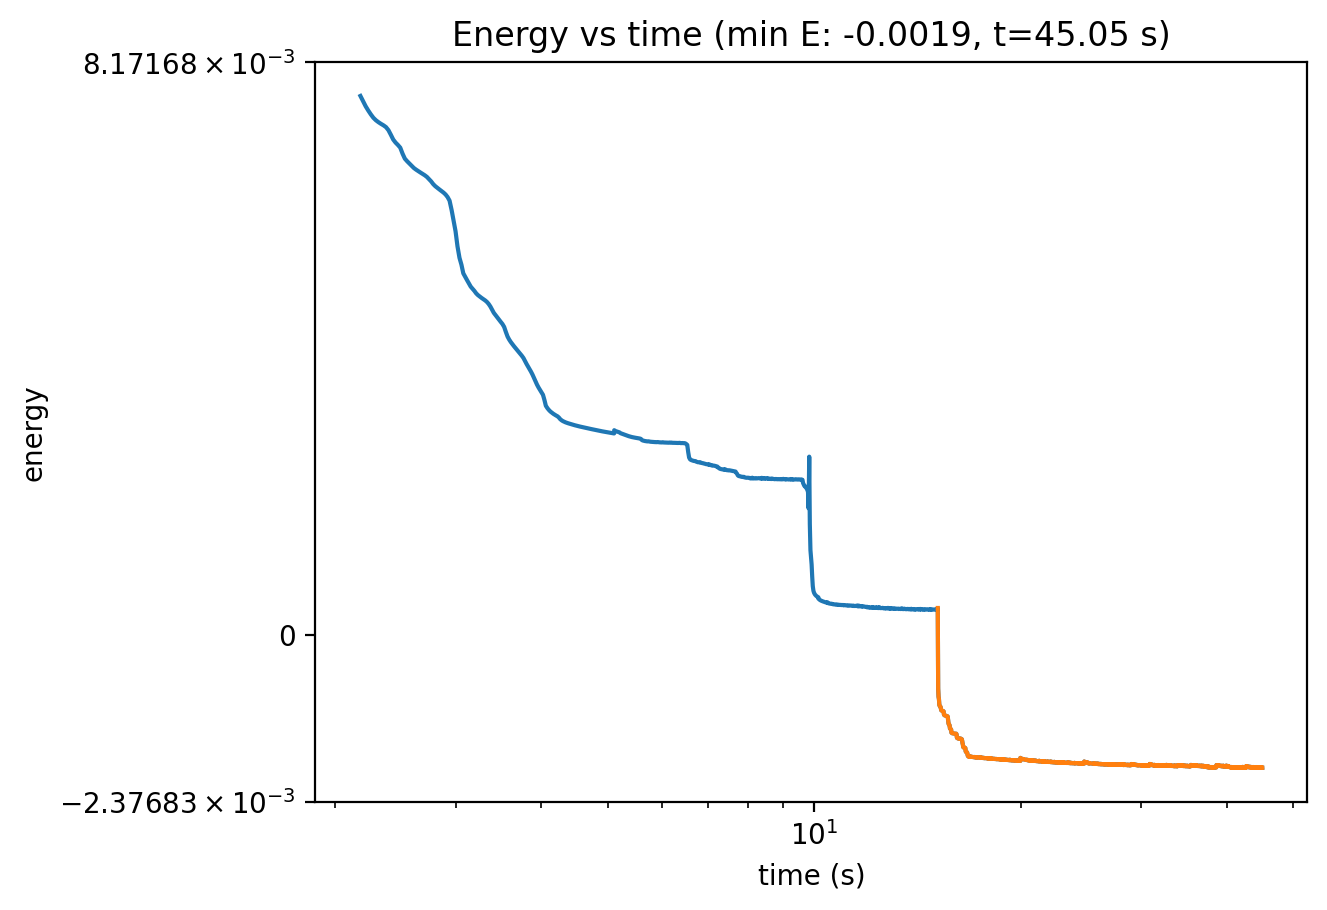

In [102]:
cg_minimizer.plot_history(start=100)
cg_minimizer.plot_history(start=cg_minimizer.cg_steps+0)
h = cg_minimizer.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g}, t={np.sum(h["time"]):.2f} s)')


In [103]:
cg_minimizer.fine_grained

True

In [111]:
r = 2.5e-1
# v = plot_graph_3D(V(cg_minimizer.get_x()), A, node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='red', edge_color='red')
v = plot_line_3D(V(cg_minimizer.get_x()), A, r = r, eps=1e-4, colormap='jet')

# Capture the current view as a PNG image
# v.png()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [35]:
# h = cg_minimizer.train_one_stage(20000)

In [36]:
cg_minimizer.history.keys()

dict_keys(['time', 'energy', 'x', 'x_cg'])

In [37]:
t0 = time.time()
# x_samples = init_sigma/2*torch.randn(4*n, n, d, device =device)
# note: large init_sigma resulted in diverging hessian
# x_samples = init_sigma*1*torch.randn(4*n, n, d, device =device)
k = 10
# produce k samples with different std for x

x0 = cg_minimizer.get_x().detach().clone()
s = x0.std().item()

x_samples = s/10*torch.randn(k, n, d, device = device)*torch.linspace(2e-1, 1e0, k)[:, None, None].to(device)
x_samples = x_samples + x0

cg_bond_lj = cg.CG.CoarseGrainer(energy_lj, num_cg_modes=120)
cg_bond_lj.get_cg_modes(x_samples)
cg_time = time.time() - t0
cg_time

force constant matrix computed in 0.07 seconds
spectrum of the Laplacian computed in 0.01 seconds


0.08427906036376953

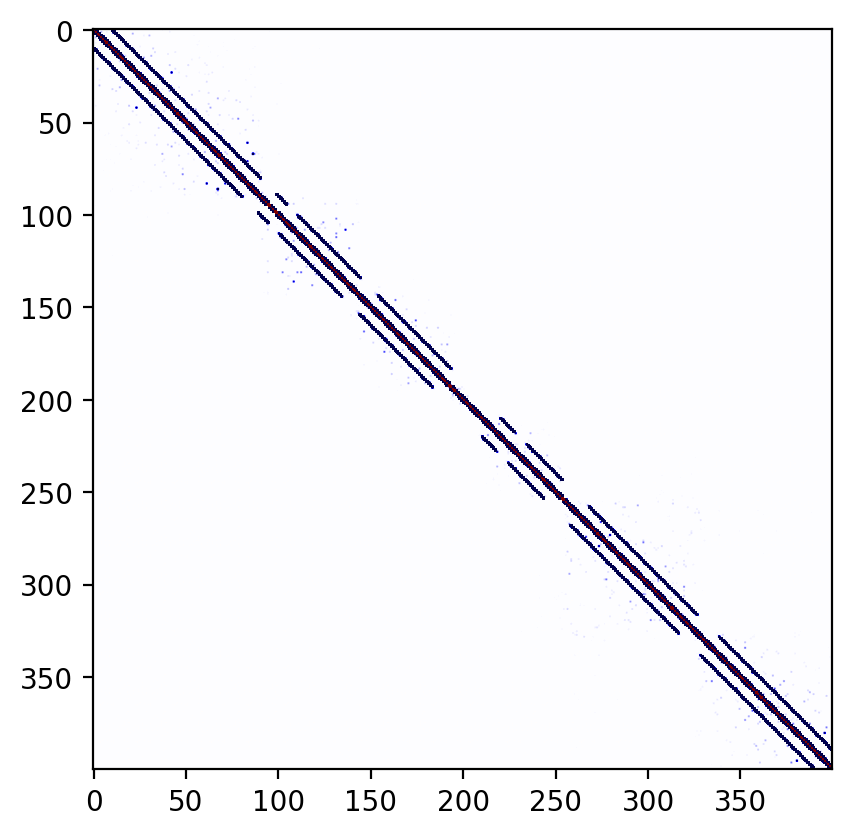

In [38]:
b = 1e-3
plt.imshow(np.arcsinh(1e3*V(cg_bond_lj.L)), cmap='seismic', vmin=-b, vmax=b)


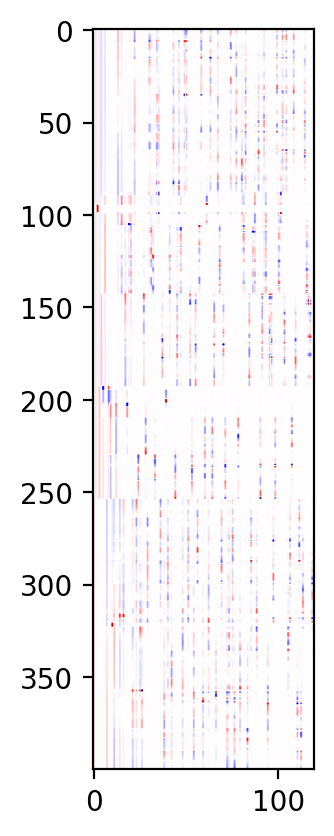

In [39]:
c = V(cg_bond_lj.cg_modes)
plt.imshow(c, cmap='seismic', vmin=-1, vmax=1) 

In [36]:
x.std()

tensor(0.9358, device='cuda:0')

## GNN

In [146]:
from coarsegrainer.GNN import GNNReparam
# example of using the GNNMinimizerPytorch class
# define the initial position
initial_pos = x = init_sigma*torch.randn(n, d).to(device)/4 #/4 
print(f"Initial std of x: {x.std().item():.3g}")

# example of using the GNNReparam class
h=200
num_cg_modes = n//4

n = len(A)
# similar to xavier initialization, we can set latent_sigma to 1/sqrt(h)
gnn_reparam = GNNReparam([h, h//1,h, d], cg=cg_bond_lj, num_cg=num_cg_modes, # latent_sigma=1/np.sqrt(h), 
                        bias=True, activation=torch.nn.ReLU(),
                        output_init_sigma= x.std().item(), 
                        device=device,
                        residual=True
                        )#.to(device)
# print(f"std before rescaling {gnn_reparam().std().item():.3g}")
# gnn_reparam.rescale_output(x.std().item())

# since std of x is init_sigma, std of gnn_reparam should be init_sigma
# but because of the gnn, it is not
# we can use the last linear layer to scale the output to match x
# we can use the std of the last layer to scale the output
# we will rescale the parameters of the last layer to match the std of x

# init_gnn_std = gnn_reparam().std()
# # rescale the weights of the last layer by the ratio of the stds
# # gnn_reparam.gnn.layers[-1].weight.data *= init_sigma/init_gnn_std*1.

# gnn_reparam.gnn.layers[-1].weight.data *= x.std().item()/init_gnn_std*1.
print(f"std after rescaling {gnn_reparam().std().item():.3g}")

# instantiate the GNNMinimizerPytorch class
# gnn_minimizer = GNNMinimizerPytorch(
gnn_minimizer = GNNMinimizer(
    energy_bond_lj, 1*initial_pos, gnn_reparam, optimizer_type='Adam', 
                            lr=1*LR, lr_gnn=LR*1e-2,
                            # lr=2*LR, lr_gnn=4e-3,
                            clamp_grads=1e-2, log_step=20, log_pos_step=0, 
                            log_dir='../results/logs', log_name=f'GNN_Bond_LJ2-{num_cg_modes/n:.2f}',
                            patience=PATIENCE, min_delta=MIN_DELTA*1e-0, 
                            gnn_patience=PATIENCE, gnn_min_delta=MIN_DELTA*1e-0)


Initial std of x: 0.911
std after rescaling 2.87
Using Adam optimizer
Log name: GNN_Bond_LJ2-0.25
Logging to: ../results/logs/GNN_Bond_LJ2-0.25_n400_d3
Using Adam optimizer


In [147]:
LR

0.02

In [148]:
gnn_minimizer.energy_func(x), gnn_minimizer.energy_func(gnn_minimizer.get_x())

(tensor(2.2039, device='cuda:0'),
 tensor(8.3890, device='cuda:0', grad_fn=<AddBackward0>))

In [149]:
# gnn_minimizer.min_delta *= 1e-1

In [150]:
# for i in range(20):
#     gnn_minimizer.early_stop.reset()
#     h= super(GNNMinimizer, gnn_minimizer).train(20000, update_pairs=True)

In [151]:
exp_logger.run_experiment(gnn_minimizer, epochs=10, steps=5000, x0_std=initial_pos.std().item())

Running experiment GNN_Bond_LJ2-0.25_n400_d3
250 -0.0229, 8.12
500 -0.0231, 16.01
Early stopping at step 3740
Starting fine-graining
938 -0.0233, 26.71
1188 -0.0233, 31.49
Early stopping at step 2300
1304 -0.0233, 33.73


In [152]:
for i in range(10):
    h= gnn_minimizer.train(20000)

Early stopping at step 2060
Early stopping at step 1320
Early stopping at step 1640
Early stopping at step 1220
Early stopping at step 1060
Early stopping at step 920
Early stopping at step 860
Early stopping at step 1140
Early stopping at step 840
Early stopping at step 780


In [52]:
gnn_minimizer.early_stop.min_delta

1e-07

Text(0.5, 1.0, 'Energy vs time (min E: -0.0233, t=45.62 s)')

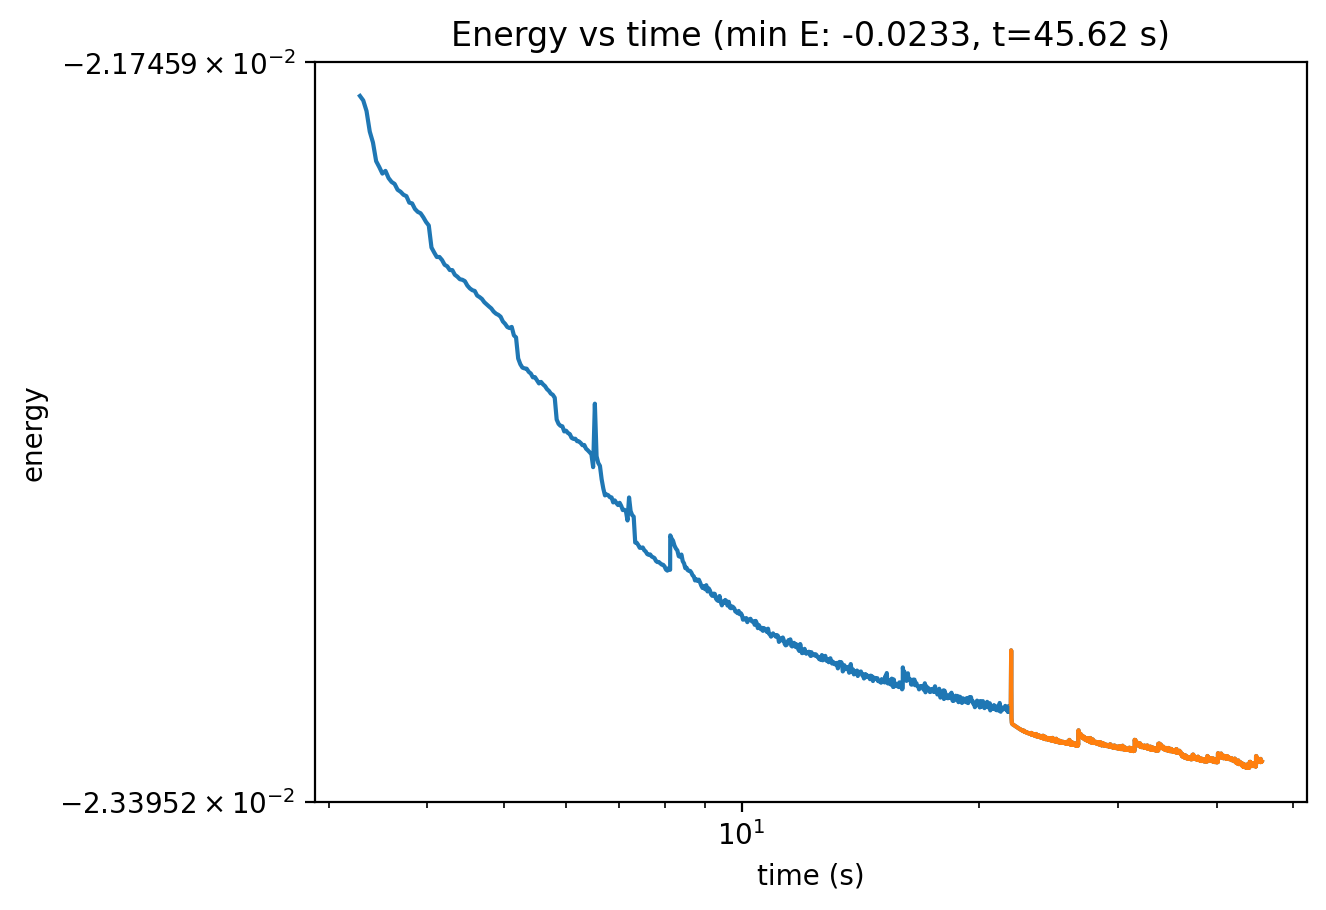

In [153]:
gnn_minimizer.plot_history(start=100)
gnn_minimizer.plot_history(start=gnn_minimizer.gnn_steps)
h = gnn_minimizer.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g}, t={np.sum(h["time"]):.2f} s)')


In [154]:
r = 3e-1
# v = plot_graph_3D(V(cg_minimizer.get_x()), A, node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='red', edge_color='red')
v = plot_line_3D(V(gnn_minimizer.get_x()), A, r = r, eps=1e-4, colormap='jet')

# Capture the current view as a PNG image
# v.png()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

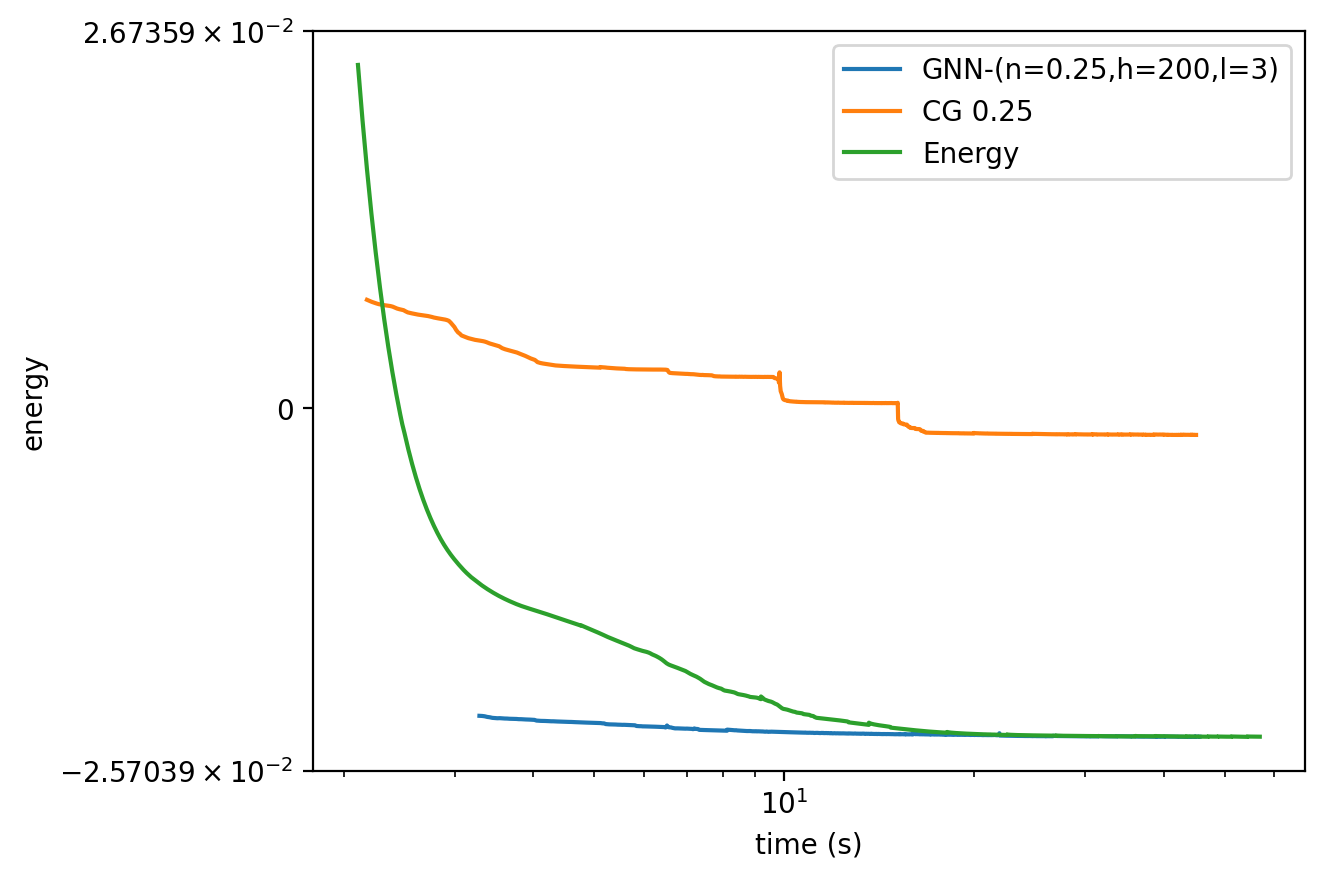

In [160]:
gnn_minimizer.plot_history(start=100)
cg_minimizer.plot_history(start=100)
energy_minimizer.plot_history(start=100)
# gnn_minimizer.plot_history(start=gnn_minimizer.gnn_steps)
h = gnn_minimizer.history
# plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g}, t={np.sum(h["time"]):.2f} s)')

plt.legend(['GNN (r=0.25,h=200,l=3)', 'CG (r=0.25)', 'Energy'])

### Using Adj matrix

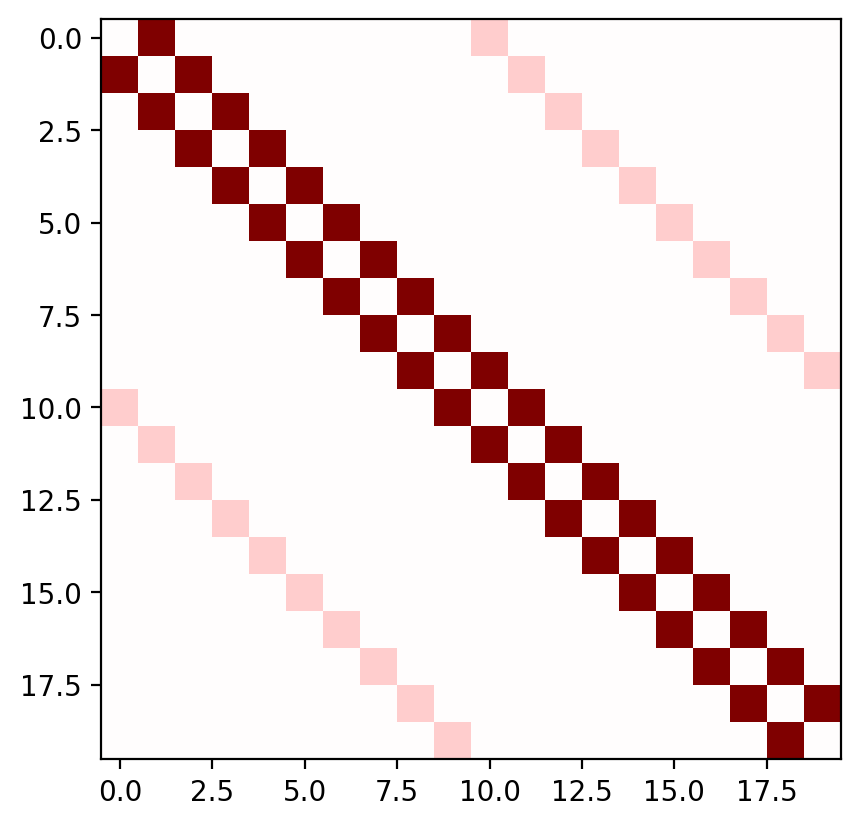

In [23]:
plt.imshow(V(A_loop)[:20,:20], cmap='seismic', vmin=-1, vmax=1)

In [24]:
# from coarsegrainer.GNN import GNNReparam
# example of using the GNNMinimizerPytorch class
# define the initial position
initial_pos = x = init_sigma*torch.randn(n, d).to(device)/4
print(f"Initial std of x: {x.std().item():.3g}")

# example of using the GNNReparam class
h=20
num_cg_modes = n//3

n = len(A)
# similar to xavier initialization, we can set latent_sigma to 1/sqrt(h)
gnn_reparam = GNNReparam([h, h//2, d], A=A_loop, # latent_sigma=1/np.sqrt(h), 
                        bias=True, activation=torch.nn.Tanh(), output_init_sigma= x.std().item(), 
                        device=device,
                        )#.to(device)
# print(f"std before rescaling {gnn_reparam().std().item():.3g}")
# gnn_reparam.rescale_output(x.std().item())

# since std of x is init_sigma, std of gnn_reparam should be init_sigma
# but because of the gnn, it is not
# we can use the last linear layer to scale the output to match x
# we can use the std of the last layer to scale the output
# we will rescale the parameters of the last layer to match the std of x

# init_gnn_std = gnn_reparam().std()
# # rescale the weights of the last layer by the ratio of the stds
# # gnn_reparam.gnn.layers[-1].weight.data *= init_sigma/init_gnn_std*1.

# gnn_reparam.gnn.layers[-1].weight.data *= x.std().item()/init_gnn_std*1.
print(f"std after rescaling {gnn_reparam().std().item():.3g}")

# instantiate the GNNMinimizerPytorch class
# gnn_minimizer = GNNMinimizerPytorch(
gnn_minimizer = GNNMinimizer(
    energy_lj, 1*initial_pos, gnn_reparam, optimizer_type='Adam', 
                            lr=1*LR, lr_gnn=2e-3,
                            # lr=2*LR, lr_gnn=4e-3,
                            clamp_grads=1e-2, log_step=20, log_pos_step=0, 
                            log_dir='../results/logs', log_name=f'GNN_Bond_LJ{num_cg_modes/n:.2f}',
                            patience=PATIENCE, min_delta=MIN_DELTA*1e-1, 
                            gnn_patience=PATIENCE, gnn_min_delta=MIN_DELTA*1e-1)


Initial std of x: 0.93
std after rescaling 0.782
Using Adam optimizer
Log name: GNN_Bond_LJ0.33
Logging to: ../results/logs/GNN_Bond_LJ0.33_n400_d3
Using Adam optimizer


In [25]:
gnn_minimizer.energy_func(x), gnn_minimizer.energy_func(gnn_minimizer.get_x())

(tensor(1.4936, device='cuda:0'),
 tensor(4.6941, device='cuda:0', grad_fn=<AddBackward0>))

In [26]:
exp_logger.run_experiment(gnn_minimizer, epochs=10, steps=5000, x0_std=initial_pos.std().item())

Running experiment GNN_Bond_LJ0.33_n400_d3


250 1.42, 5.09
500 1.42, 10.04
750 1.42, 14.98
Early stopping at step 4260
Starting fine-graining
Early stopping at step 3260
1128 1.42, 21.60


In [27]:
# for i in range(10):
#     h= gnn_minimizer.train(20000)

Text(0.5, 1.0, 'Energy vs time (min E: 1.42, t=21.60 s)')

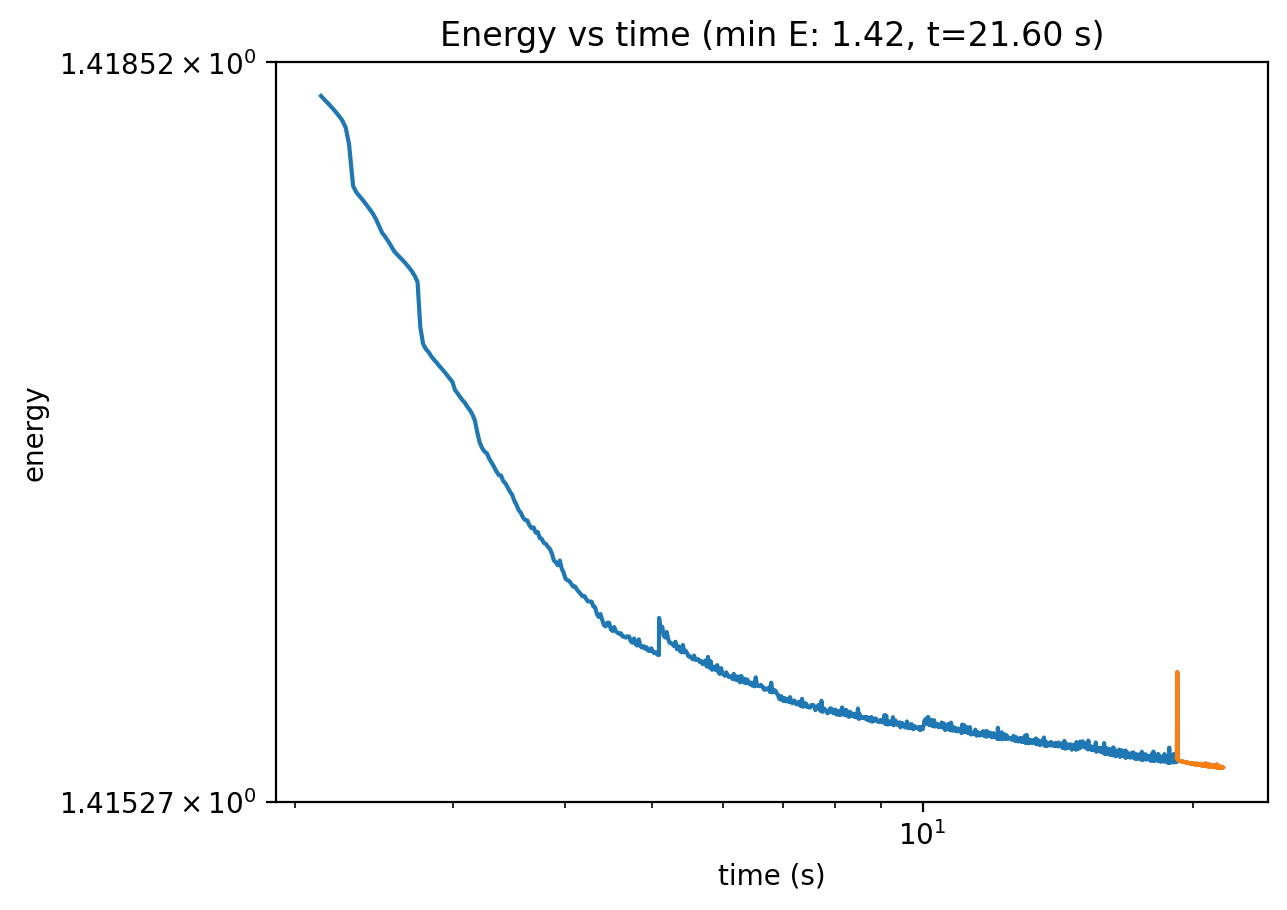

In [28]:
gnn_minimizer.plot_history(start=100)
gnn_minimizer.plot_history(start=gnn_minimizer.gnn_steps)
h = gnn_minimizer.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g}, t={np.sum(h["time"]):.2f} s)')


In [29]:
r = 3e-1
# v = plot_graph_3D(V(cg_minimizer.get_x()), A, node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='red', edge_color='red')
v = plot_line_3D(V(gnn_minimizer.get_x()), A, r = r, eps=1e-4, colormap='jet')

# Capture the current view as a PNG image
# v.png()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Using edgelist

In [10]:
# add the value of A[i,j] as the third column in edgelist
edgelist = torch.where(A_loop.abs() > 1e-4)
edgelist = torch.cat([edgelist[0][:, None], edgelist[1][:, None], A_loop[edgelist].view(-1,1)], dim=1)
edgelist

tensor([[0.0000e+00, 1.0000e+00, 1.0000e+00],
        [0.0000e+00, 1.0000e+01, 1.0000e-01],
        [1.0000e+00, 0.0000e+00, 1.0000e+00],
        ...,
        [3.9800e+02, 3.9900e+02, 1.0000e+00],
        [3.9900e+02, 3.8900e+02, 1.0000e-01],
        [3.9900e+02, 3.9800e+02, 1.0000e+00]], device='cuda:0')

In [11]:
edgelist.shape

torch.Size([1578, 3])

In [18]:
from coarsegrainer.GNN import GNNReparam
# example of using the GNNMinimizerPytorch class
# define the initial position
initial_pos = x = init_sigma*torch.randn(n, d).to(device)/4
print(f"Initial std of x: {x.std().item():.3g}")

# example of using the GNNReparam class
h=20
num_cg_modes = n//3

n = len(A)
# similar to xavier initialization, we can set latent_sigma to 1/sqrt(h)
gnn_reparam = GNNReparam([h, h//2, d], edgelist=edgelist, # latent_sigma=1/np.sqrt(h), 
                        bias=True, activation=torch.nn.Tanh(), output_init_sigma= x.std().item(), 
                        device=device,
                        )#.to(device)
# print(f"std before rescaling {gnn_reparam().std().item():.3g}")
# gnn_reparam.rescale_output(x.std().item())

# since std of x is init_sigma, std of gnn_reparam should be init_sigma
# but because of the gnn, it is not
# we can use the last linear layer to scale the output to match x
# we can use the std of the last layer to scale the output
# we will rescale the parameters of the last layer to match the std of x

# init_gnn_std = gnn_reparam().std()
# # rescale the weights of the last layer by the ratio of the stds
# # gnn_reparam.gnn.layers[-1].weight.data *= init_sigma/init_gnn_std*1.

# gnn_reparam.gnn.layers[-1].weight.data *= x.std().item()/init_gnn_std*1.
print(f"std after rescaling {gnn_reparam().std().item():.3g}")

# instantiate the GNNMinimizerPytorch class
# gnn_minimizer = GNNMinimizerPytorch(
gnn_minimizer = GNNMinimizer(
    energy_lj, 1*initial_pos, gnn_reparam, optimizer_type='Adam', 
                            lr=1*LR, lr_gnn=2e-3,
                            # lr=2*LR, lr_gnn=4e-3,
                            clamp_grads=1e-2, log_step=20, log_pos_step=0, 
                            log_dir='../results/logs', log_name=f'GNN_Bond_LJ{num_cg_modes/n:.2f}',
                            patience=PATIENCE, min_delta=MIN_DELTA*1e-1, 
                            gnn_patience=PATIENCE, gnn_min_delta=MIN_DELTA*1e-1)


Initial std of x: 0.892
std after rescaling 0.862
Using Adam optimizer
Log name: GNN_Bond_LJ0.33
Logging to: ../results/logs/GNN_Bond_LJ0.33_n400_d3
Using Adam optimizer


In [19]:
gnn_minimizer.energy_func(x), gnn_minimizer.energy_func(gnn_minimizer.get_x())

(tensor(1.9723, device='cuda:0'),
 tensor(1.7545, device='cuda:0', grad_fn=<AddBackward0>))

In [20]:
exp_logger.run_experiment(gnn_minimizer, epochs=10, steps=5000, x0_std=initial_pos.std().item())

Running experiment GNN_Bond_LJ0.33_n400_d3


250 0.463, 6.71
500 0.462, 13.14
Early stopping at step 2600
Starting fine-graining
Early stopping at step 4040
834 0.462, 19.63


In [24]:
for i in range(3):
    h= gnn_minimizer.train(20000)

Early stopping at step 9840
Early stopping at step 4640
Early stopping at step 1880


Text(0.5, 1.0, 'Energy vs time (min E: 0.462, t=31.25 s)')

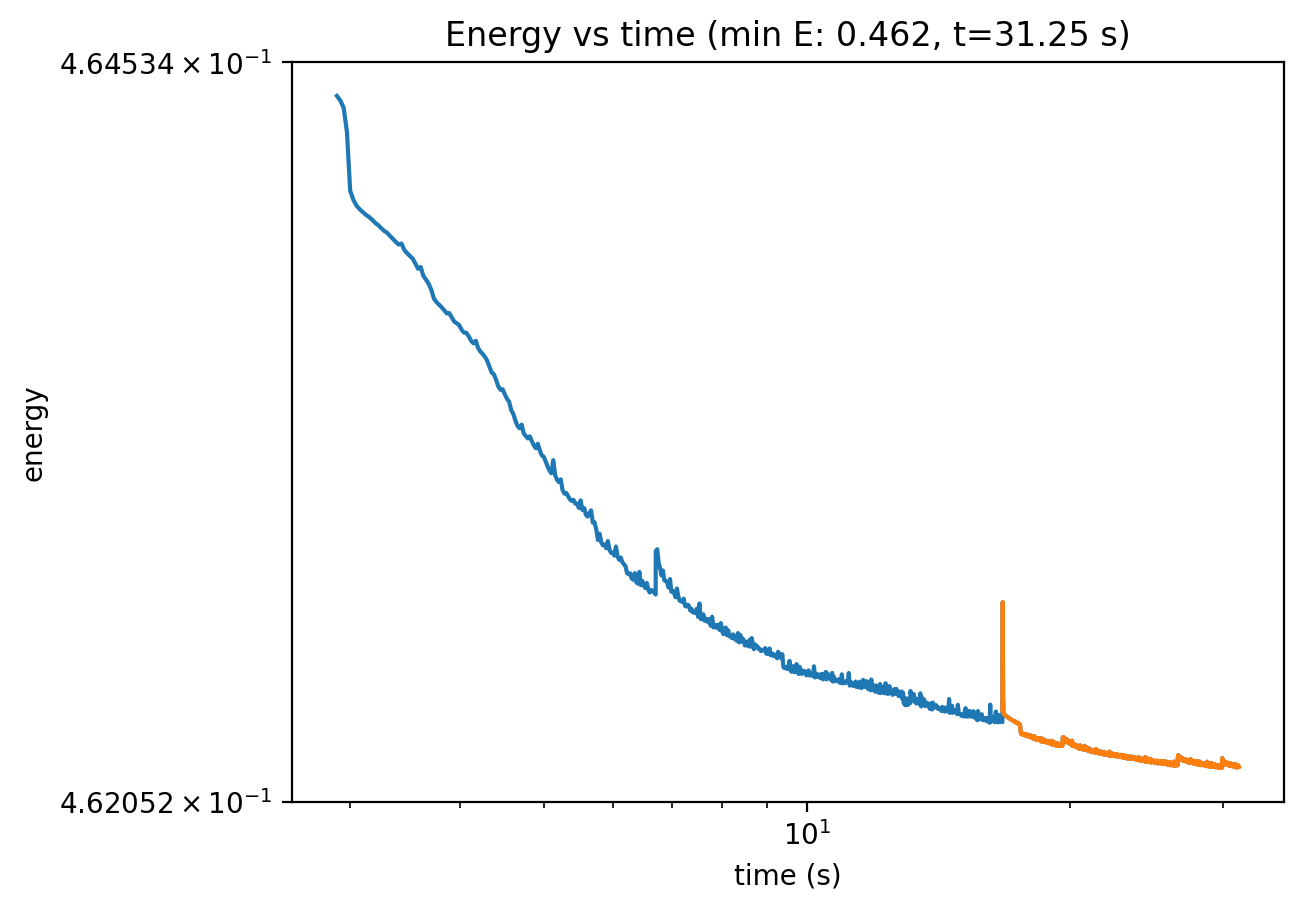

In [25]:
gnn_minimizer.plot_history(start=100)
gnn_minimizer.plot_history(start=gnn_minimizer.gnn_steps)
h = gnn_minimizer.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g}, t={np.sum(h["time"]):.2f} s)')


In [26]:
r = 3e-1
# v = plot_graph_3D(V(cg_minimizer.get_x()), A, node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='red', edge_color='red')
v = plot_line_3D(V(gnn_minimizer.get_x()), A, r = r, eps=1e-4, colormap='jet')

# Capture the current view as a PNG image
# v.png()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol